# Detección de objetos y aprendizaje máquina

El mundo está compuesto de objetos. Cada objeto posee sus propias 
características que lo hacen único de los demás pero que también lo
hacen similar a otros. Entender las escenas a través de los objetos 
es una de las tareas clave en visión por computadora. OpenCV provee
diferentes algoritmos y herramientas para poder realizar la detección
y seguimiento de objetos.

Se muestra:

* Obtener objetos con el algoritmo GrabCut
* Obtener contornos con el algoritmo de Canny
* Detectar líneas y círculos utilizando la transformada de Hough
* Encontrar objetos con base en plantillas
* Seguidor de objetos en tiempo real
* Calcular el flujo de la densidad óptica
* Detectar patrones de rejillas
* Detectar personas con Máquinas de Soporte Vectorial
* Reconocedor de caracteres
* Detectar rostros utilizando Haar/LBP
* Detectar patrones para aplicaciones de Realidad Aumentada
* Detectar códigos QR

## Bibliotecas utilizadas

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

## Buscar objetos con el algoritmo GrabCut

#### Imagen original

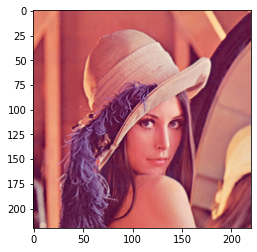

In [31]:
imagen = cv2.imread('img/lena.png', cv2.IMREAD_COLOR)
imagen_muestra = np.copy(imagen)
plt.imshow(imagen[:, :, [2,1,0]])

#### Callback para dibujar rectangulo sobre la imagen

In [32]:
mouse_presionado = False
y = x = w = h =  0

def mouse_callback(evento, _x, _y, banderas, parametros):
    global imagen_muestra, x, y, w, h, mouse_presionado
    
    if evento == cv2.EVENT_LBUTTONDOWN:
        mouse_presionado = True
        x, y = _x, _y
        imagen_muestra = np.copy(imagen)
        
    elif evento == cv2.EVENT_MOUSEMOVE:
        if mouse_presionado:
            imagen_muestra = np.copy(imagen)
            cv2.rectangle(imagen_muestra, (x, y), (_x, _y), (0, 255, 0), 3)
            
    elif evento == cv2.EVENT_LBUTTONUP:
        mouse_presionado = False
        w, h, = _x - x, _y - y

#### Mostrar imagen y aplicar el algoritmo

Seleccionar una región rectangular con el *mouse* y presionar la tecla `a`
para guardar la región.

In [34]:
cv2.namedWindow('Imagen')
cv2.setMouseCallback('Imagen', mouse_callback)

while True:
    cv2.imshow('Imagen', imagen_muestra)
    k = cv2.waitKey(1)
    
    if k == ord('a') and not mouse_presionado:
        if w*h > 0:
            break
            
    elif k == 27:
        break
        
cv2.destroyAllWindows()

#### Utilizar `cv2.grabCut` para crear una máscara con base en el rectángulo seleccionado anteriormente

In [35]:
etiquetas = np.zeros(imagen.shape[:2], np.uint8)

etiquetas, modelo_bgd, modelo_fgd = cv2.grabCut(imagen, etiquetas, (x, y, w, h), None, None, 5, cv2.GC_INIT_WITH_RECT)

imagen_muestra = np.copy(imagen)
imagen_muestra[(etiquetas == cv2.GC_PR_BGD) | (etiquetas == cv2.GC_BGD)] //= 3

plt.imshow(imagen_muestra[:, :, [2, 1, 0]])

#### Definir callback para dibujar la máscara en la imagen. Es necesario reparar ciertos detalles en la llamada a `cv2.cutGrab`

In [36]:
etiqueta = cv2.GC_BGD
etiqueta_circulos = {cv2.GC_BGD: (0,0,0), cv2.GC_FGD: (255, 255, 255)}

def mouse_callback(evento, x, y, banderas, parametros):
    global mouse_presionado
    
    if evento == cv2.EVENT_LBUTTONDOWN:
        mouse_presionado = True
        cv2.circle(etiquetas, (x, y), 5, etiqueta, cv2.FILLED)
        cv2.circle(imagen_muestra, (x, y), 5, etiqueta_circulos[etiqueta], cv2.FILLED)
        
    elif evento == cv2.EVENT_MOUSEMOVE:
        if mouse_presionado:
            cv2.circle(etiquetas, (x, y), 5, etiqueta, cv2.FILLED)
            cv2.circle(imagen_muestra, (x, y), 5, etiqueta_circulos[etiqueta], cv2.FILLED)
            
    elif evento == cv2.EVENT_LBUTTONUP:
        mouse_presionado = False

#### Mostrar la imagen con la máscara

Se utiliza color negro donde los pixeles del objeto están etiquetados como *background* y se utiliza blanco para las áreas que pertenecen al objeto.

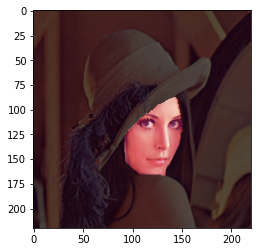

In [41]:
cv2.namedWindow('Imagen')
cv2.setMouseCallback('Imagen', mouse_callback)

while True:
    cv2.imshow('Imagen', imagen_muestra)
    k = cv2.waitKey(1)
    
    if k == ord('a') and not mouse_presionado:
        break
    elif k == ord('1'):
        etiqueta = cv2.GC_FGD - etiqueta
    elif k == 27:
        break
cv2.destroyAllWindows()
        
etiquetas, modelo_bgd, modelo_fgd = cv2.grabCut(imagen, etiquetas, None, modelo_bgd, modelo_fgd, 5, cv2.GC_INIT_WITH_MASK)
imagen_muestra = np.copy(imagen)
imagen_muestra[(etiquetas == cv2.GC_PR_BGD) | (etiquetas == cv2.GC_BGD)] //= 3

plt.imshow(imagen_muestra[:, :, [2, 1, 0]])

## Obtener bordes con el algoritmo Canny

Los bordes son una característica muy útil para las aplicaciones de visión por computadora. OpenCV provee la función `cv2.Canny`.

#### Imagen original

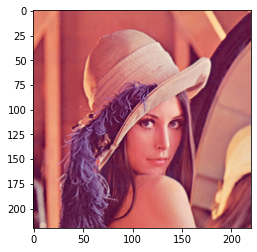

In [42]:
imagen = cv2.imread('img/lena.png')
plt.imshow(imagen[:, :, [2,1,0]])

## Aplicar Canny

El algoritmo recibe dos parámetros que representan dos umbrales para la magnitud del gradiente, el primero para la detección de bordes marcados y el segundo es usado en el proceso de histéresis.

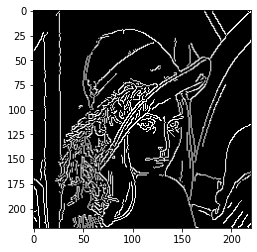

In [43]:
bordes = cv2.Canny(imagen, 200, 100)
plt.imshow(bordes, cmap='gray')

#### Cambiando los paŕametros (500, 50)

In [44]:
bordes = cv2.Canny(imagen, 500, 50)
plt.imshow(bordes, cmap='gray')

#### Prueba con los parámetros: (500, 500)

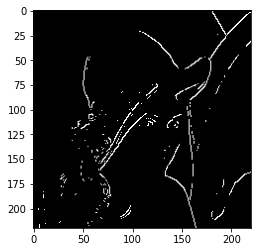

In [45]:
bordes = cv2.Canny(imagen, 500, 500)
plt.imshow(bordes, cmap='gray')

## Detección de líneas y círculos utilizando la transformada de Hough

La transformada de Hough es una técnica para la detección de cualquier forma parametrizada y representada en una forma matemática conveniente.
Básicamente, para cada pixel en la imagen original, la transformada
de Hough encuentra un conjunto de parámetros que satisfacen la observación
y se almacenan en una tabla. Cada pixel vota por un subconjunto de modelos
posibles. Las formas detectadas se obtienen mediante un proceso de votos.

#### Creando una imagen inicial con un círculo y una línea

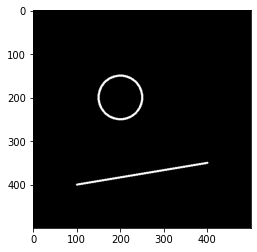

In [50]:
imagen = np.zeros((500, 500), np.uint8)
cv2.circle(imagen, (200, 200), 50, 255, 3)
cv2.line(imagen, (100, 400), (400, 350), 255, 3)
plt.imshow(imagen, cmap='gray')

#### Aplicar transformada Hough probabilística

`cv2.HoughLinesP` no es la implementación original, sino que es una 
versión optimizada con probabilidad. La función toma como parámetros:

* Imagen original
* Resolución espacial del espacio de votación
* Resolución espacial del ángulo de votación
* Umbral para el voto mínimo
* Longitud mínima de la línea
* Máxima distancia entre dos puntos sobre la línea

Devuelve una lista de las líneas detectadas.

`cv2.HoughCircles` toma como parámetros:

* Imagen original
* Método de detección
    Por ahora solo es soportado `cv2.HOUGH_GRADIENT`
* Resolución espacial inversa de votación
* Distancia mínima entre los centros de los círculos detectados
* Dos opcionales:
    * param1: Máximo umbral para algoritmo de Canny
    * param2: Umbral para el contador de votos

Devuelve una lista con los cículos encontrados.

In [51]:
lineas = cv2.HoughLinesP(imagen, 1, np.pi/180, 100, 100, 10)[0]
circulos = cv2.HoughCircles(imagen, cv2.HOUGH_GRADIENT, 1, 15, param1=100, param2=30)[0]

#### Dibujar líneas y círculos detectados

Se dibujan de color verde las lineas y círculos detectados.

Linea detectada: (99, 401) (372, 353)
Círculo detectado: centro=(200.5, 200.5) radio=52.29999923706055


<ipython-input-53-a5354b082768>:7: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(imagen_dibujo, (c[0], c[1]), int(c[2]), (0, 255, 0), 2)


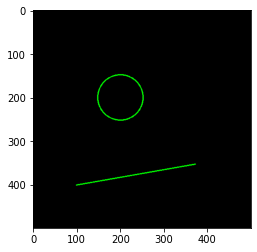

In [53]:
imagen_dibujo = np.zeros((imagen.shape[0], imagen.shape[1], 3), np.uint8)
for x1, y1, x2, y2 in lineas:
    print('Linea detectada: ({}, {}) ({}, {})'.format(x1, y1, x2, y2))
    cv2.line(imagen_dibujo, (x1, y1), (x2, y2), (0, 255, 0), 2)
for c in circulos:
    print('Círculo detectado: centro=({}, {}) radio={}'.format(c[0], c[1], c[2]))
    cv2.circle(imagen_dibujo, (c[0], c[1]), int(c[2]), (0, 255, 0), 2)
plt.imshow(imagen_dibujo)

#### Prueba con otra imagen

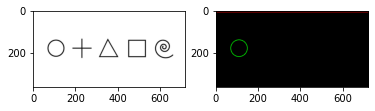

In [55]:
imagen = cv2.imread('img/lineasycirculos.jpg', cv2.IMREAD_GRAYSCALE)
lineas = cv2.HoughLinesP(imagen, 0.5, np.pi/180, 100, 100, 10)[0]
circulos = cv2.HoughCircles(imagen, cv2.HOUGH_GRADIENT, 0.15, 70, param1=100, param2=60)[0]
imagen_dibujo = np.zeros((imagen.shape[0], imagen.shape[1], 3), np.uint8)
for x1, y1, x2, y2 in lineas:
    cv2.line(imagen_dibujo, (x1, y1), (x2, y2), (255, 0, 0), 2)
for c in circulos:
    cv2.circle(imagen_dibujo, (int(c[0]), int(c[1])), int(c[2]), (0, 255, 0), 2)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imagen, cmap='gray')
ax2.imshow(imagen_dibujo)

## Detección de objetos utilizando plantillas

La función `cv2.matchTemplate` se utiliza para encontrar regiones en la 
imagen que sean similares a la plantilla. Esta similitud puede ser 
aproximada por diversos métodos. Sin embargo ninguno de estos métodos
es capaz de buscar plantillas con diferentes escalas u orientaciones.

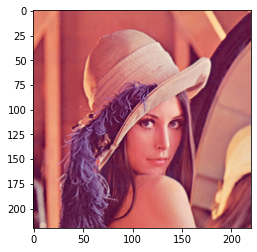

In [56]:
imagen = cv2.imread('img/lena.png', cv2.IMREAD_COLOR)
imagen_muestra = np.copy(imagen)
plt.imshow(imagen[:, :, [2, 1, 0]])

#### Se define callback para seleccionar úna región de interés que servirá como plantilla

In [57]:
mouse_presionado = False
x = y = w = h = 0

def mouse_callback(evento, _x, _y, banderas, parametros):
    global imagen_muestra, x, y, w, h, mouse_presionado
    
    if evento == cv2.EVENT_LBUTTONDOWN:
        mouse_presionado = True
        x, y = _x, _y
        imagen_muestra = np.copy(imagen)
        
    elif evento == cv2.EVENT_MOUSEMOVE:
        if mouse_presionado:
            imagen_muestra = np.copy(imagen)
            cv2.rectangle(imagen_muestra, (x, y), (_x, _y), (0, 255, 0), 2)
    
    elif evento == cv2.EVENT_LBUTTONUP:
        mouse_presionado = False
        w, h = _x - x, _y -y

#### Mostrar imagen para seleccionar región

Presionar la tecla *a* para guardar la región y cerrar la ventana

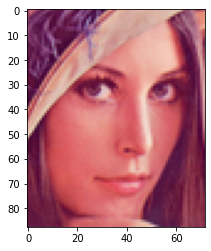

In [58]:
cv2.namedWindow('Imagen')
cv2.setMouseCallback('Imagen', mouse_callback)

while True:
    cv2.imshow('Imagen', imagen_muestra)
    k = cv2.waitKey(1)
    
    if k == ord('a') and not mouse_presionado:
        if w*h > 0:
            break
    elif k == 27:
        break
cv2.destroyAllWindows()

plantilla = np.copy(imagen[y:y+h, x:x+w])
plt.imshow(plantilla[:, :, [2, 1, 0]])

#### Aplicar algoritmo

La fuinción toma como argumentos:

* Imagen donde se quiere buscar
* Plantilla que se va a buscar
* Método a utilizar
    * Aquellos que llevan CCOEFF utilizan el coeficiente de correlación
    * Aquellos que llevan CCORR utilizan la correlación cruzada
    * Aquellos que llevan SQDIFF utilizan la diferencia cuadrática


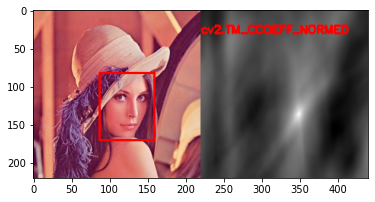

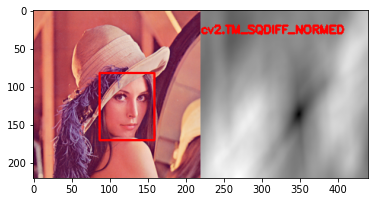

In [59]:
metodos = ['cv2.TM_CCOEF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
imagen_muestra = np.copy(imagen)

for indice in range(1, len(metodos)):
    metodo = metodos[indice]
    resultado = cv2.matchTemplate(imagen, plantilla, eval(metodo))
    resultado = cv2.normalize(resultado, None, 0, 1, cv2.NORM_MINMAX)
    if indice >= metodos.index('cv2.TM_SQDIFF'):
        loc = np.where(resultado < 0.01)
    else:
        loc = np.where(resultado > 0.99)
    imagen_muestra = np.copy(imagen)
    for p in zip(*loc[::-1]):
        cv2.rectangle(imagen_muestra, p, (p[0] + w, p[1] + h), (0, 0, 255), 2)
    resultado = cv2.resize(resultado, imagen_muestra.shape[:2])*255
    resultado = cv2.cvtColor(resultado, cv2.COLOR_GRAY2BGR).astype(np.uint8)
    cv2.putText(resultado, metodo, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    imagen_muestra = np.hstack((imagen_muestra, resultado))
    plt.figure()
    plt.imshow(imagen_muestra[:, :, [2, 1, 0]])

## Seguidor de objetos con MedianFlow

Se muestra el seguimiento de algún objeto en un video. Funciona en 
tiempo real y lo hace de manera precisa y estable. El algoritmo cuenta
con la gran característica de determinar cuando éste falla.

#### Seleccionar objeto

Se lee el primer *frame* del video y se selecciona el objeto a seguir,
con ayuda del mouse se dibuja un rectángulo sobre el área de interés.

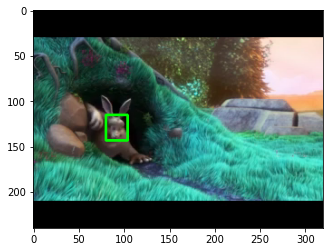

In [120]:
captura = cv2.VideoCapture('video/video_prueba.mp4')
_, frame = captura.read()
caja = cv2.selectROI(frame, False, True)
cv2.destroyAllWindows()
cv2.rectangle(frame, (caja[0], caja[1]), (caja[0]+caja[2], caja[1]+caja[3]), (0, 255, 0), 2)
plt.figure()
plt.imshow(frame)

#### Crear el seguidor

OpenCV provee la función `cv2.TrackerMedianFlow_create`. El objeto deberá ser inicializado con el 
objeto del que se quiere dar seguimiento. Posteriormente sólo se deberá
llamar el método `update` del objeto, pasando como parámetro el nuevo frame.

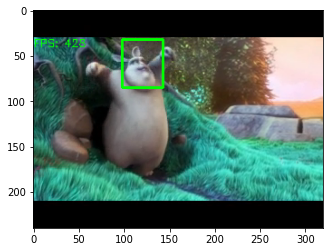

In [122]:
seguidor = cv2.TrackerMedianFlow_create()
estado_seguidor = seguidor.init(frame, caja)
fps = 0

while True:
    estado_seguidor, frame = captura.read()
    if not estado_seguidor:
        break    
    timer = cv2.getTickCount()
    estado_seguidor, caja = seguidor.update(frame)
    if estado_seguidor:
        x, y, w, h = [int(i) for i in caja]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
        cv2.putText(frame, 'FPS: %.0f' % fps, (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
        plt.imshow(frame)
    else:
        cv2.putText(frame, 'Falla', (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    cv2.imshow('Seguidor MedianFlow', frame)
    
    k = cv2.waitKey(100)
    if k == 27:
        break

cv2.destroyAllWindows()

## Seguimiento de objetos

OpenCV provee diversos algoritmos de seguimiento a través de una API. Cada
algoritmo tiene sus ventajas y desventajas, en precisión, fiabilidad y 
velocidad.

Los algoritmos utilizados son:

* Median Flow
* Kernelized Correlation Filters (KCF)
* Tracking-Learning-Detection (TLD)
* Multiple Instance Learning (MIL)

#### Crear ventana y los seguidores

Se muestra el primer *frame* del video para poder seleccionar la
región de interés y posteriormente se muestra el seguimiento con los
distintos algoritmos que ofrece la API de OpenCV.

In [124]:
video = cv2.VideoCapture('video/video_prueba.mp4')
_, frame = video.read()
caja_inicial = cv2.selectROI(frame, False, True)
cv2.namedWindow('frame')
for name, seguidor in (('MedianFlow', cv2.TrackerMedianFlow_create),
                      ('KFC', cv2.TrackerKCF_create),
                      ('MIL', cv2.TrackerMIL_create),
                      ('TLD', cv2.TrackerTLD_create)):
    video = cv2.VideoCapture('video/video_prueba.mp4')
    caja = caja_inicial
    seguidor = seguidor()
    inicializado = False

    while True:
        t0 = time.time()
        listo, frame = video.read()
        if not listo:
            break

        if inicializado:
            seguido, caja = seguidor.update(frame)
        else:
            seguido = seguidor.init(frame, caja)
            inicializado = True

        fps = 1 / (time.time() - t0)
        cv2.putText(frame, 'Seguidor: {}, fps: {}'.format(name, fps), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 0, 0), 2)
        if seguido:
            caja = tuple(map(int, caja))
            cv2.rectangle(frame,  (caja[0], caja[1]), (caja[0]+caja[2], caja[1]+caja[3]), (0, 255, 0),  2)
        cv2.imshow('frame', frame)
        
        if cv2.waitKey(30) == 27:
            break
cv2.destroyAllWindows()

## Cálculo del flujo óptico denso entre dos *frames*

El flujo óptico es una familia de algoritmos que permite obtener el
movimiento de los puntos entre dos imágenes (usualmente *frames* 
subsecuentes en un video). Se busca el movimiento de cada pixel sobre la 
imagen. Se utiliza para buscar objetos en movimiento en una secuencia
de frames o en cámaras.

#### Definir función para mostrar el flujo

In [142]:
def mostrar_flujo(imagen, flujo, salto=40):
    for indice in np.ndindex(flujo[::salto, ::salto].shape[:2]):
        punto_1 = tuple(i*salto for i in indice)
        delta = flujo[punto_1].astype(np.int32)[::-1]
        punto_2 = tuple(punto_1 + 10*delta)
        if 2 <= cv2.norm(delta) <= 10:
            cv2.arrowedLine(imagen, punto_1[::-1], punto_2[::-1], (0,0,255), 3, cv2.LINE_AA, 0, 0.4)
            norma_flujo = np.linalg.norm(flujo, axis=2)
            norma_flujo = cv2.normalize(norma_flujo, None, 0, 1, cv2.NORM_MINMAX)
            cv2.imshow('flujo', imagen)
            cv2.imshow('magnitud flujo', norma_flujo)
            fig, (ax1, ax2) = plt.subplots(1,2)
            ax1.imshow(imagen)
            ax2.imshow(norma_flujo)
            k = cv2.waitKey(500)
            if k == 27:
                return True
            else:
                return False

#### Aplicar algoritmo a video

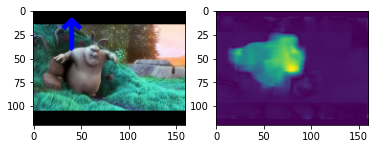

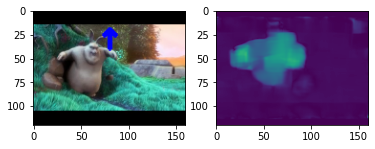

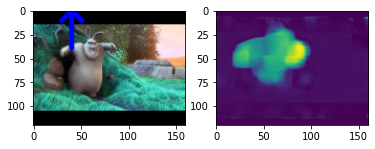

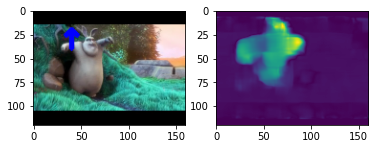

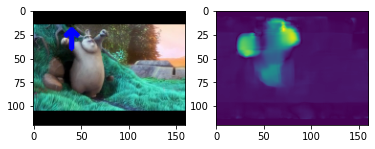

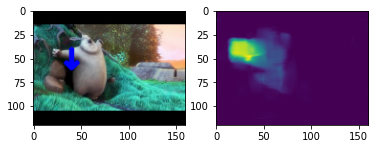

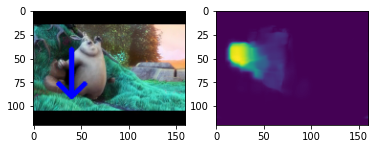

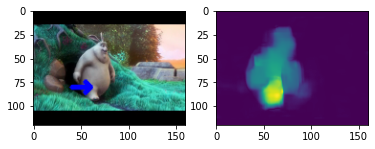

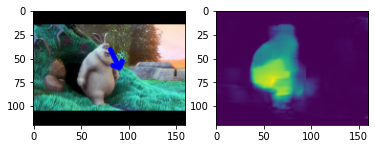

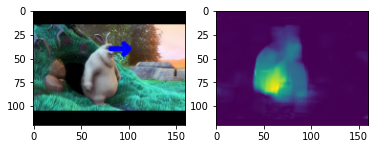

In [143]:
captura = cv2.VideoCapture('video/video_prueba.mp4')
_, frame_previo = captura.read()

frame_previo = cv2.cvtColor(frame_previo, cv2.COLOR_BGR2GRAY)
frame_previo = cv2.resize(frame_previo, (0,0), None, 0.5, 0.5)
flujo_inicial = True

while True:
    estado_captura, frame = captura.read()
    if not estado_captura:
        break
    frame = cv2.resize(frame, (0,0), None, 0.5, 0.5)
    gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if flujo_inicial:
        flujo = cv2.calcOpticalFlowFarneback(frame_previo, gris, None, 0.5, 5, 13, 10, 5, 1.1, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        flujo_inicial = False
    else:
        flujo = cv2.calcOpticalFlowFarneback(frame_previo, gris, flujo, 0.5, 5, 13, 10, 5, 1.1, cv2.OPTFLOW_USE_INITIAL_FLOW)
        frame_previo = np.copy(gris)
    if mostrar_flujo(frame, flujo):
        break
        
cv2.destroyAllWindows()

## Detectar patrones de rejillas cuadradas y circulares

#### Rejilla cuadrada

In [33]:
ajedrez = cv2.imread('img/ajedrez.png')
plt.imshow(ajedrez)

#### Se define el tamaño del tablero y se aplica el algoritmo

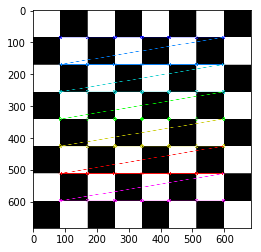

In [35]:
tamano_tablero = (7, 7)
existe, esquinas = cv2.findChessboardCorners(ajedrez, tamano_tablero)
ajedrez_esquinas = ajedrez.copy()
cv2.drawChessboardCorners(ajedrez_esquinas, tamano_tablero, esquinas, existe)
plt.imshow(ajedrez_esquinas)

#### Rejilla circular

In [41]:
circulos = cv2.imread('img/circulos.png')
plt.imshow(circulos)

In [43]:
tamano_rejilla = (8, 8)
existe, esquinas = cv2.findCirclesGrid(circulos, tamano_rejilla, cv2.CALIB_CB_SYMMETRIC_GRID)
assert existe == True, "No se encontró rejilla"
circulos_esquinas = circulos.copy()
cv2.drawChessboardCorners(circulos_esquinas, tamano_rejilla, esquinas, existe)
plt.imshow(circulos_esquinas)

## Detector de personas simple con SVM

Se utiliza un modelo entrenado con máquinas de soporte vectorial (SVM) que 
utiliza las características [HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) para clasificar. 

#### Imagen con personas

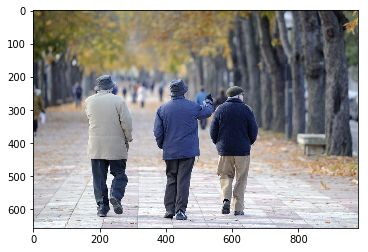

In [3]:
imagen = cv2.imread('img/personas.png')
plt.imshow(imagen[:,:,[2,1,0]])

#### Crear objeto que calcula las características HOG

In [4]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

#### Aplicar algoritmo a la imagen

La función devuelve una lista de posiciones de las personas detectadas y 
el *score* que evalúa cada una de las detecciones.

In [5]:
posiciones, pesos = hog.detectMultiScale(imagen)

#### Dibujar los cuadros de las detecciones

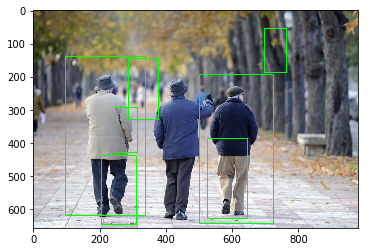

In [7]:
imagen_muestra = imagen.copy()
for p in posiciones:
    cv2.rectangle(imagen_muestra, (p[0], p[1]), (p[0] + p[2], p[1] + p[3]), (0, 255, 0), 2)
plt.imshow(imagen_muestra[:, :, [2,1,0]])

## Reconocedor de caracteres

#### Se definen algunas constantes

In [151]:
TAMANIO_IMAGEN = 20
CLASES = 10
TASA_ENTRENAMIENTO = 0.8

#### Se lee la imagen que contiene los digitos y se dividen en imágenes por cada digito

In [240]:
imagen_digitos = cv2.imread('img/digitos.png', 0)
digitos = [np.hsplit(r, imagen_digitos.shape[1] // TAMANIO_IMAGEN)
          for r in np.vsplit(imagen_digitos, imagen_digitos.shape[0] // TAMANIO_IMAGEN)]
digitos = np.array(digitos).reshape(-1, TAMANIO_IMAGEN, TAMANIO_IMAGEN)
numero_muestras = digitos.shape[0]
etiquetas = np.repeat(np.arange(CLASES), numero_muestras // CLASES)

#### Imagen original

In [194]:
print('Dimensiones imagen original: ', imagen_digitos.shape)
plt.imshow(imagen_digitos)

Dimensiones imagen original:  (1000, 2000)



#### Ejemplos de imágenes divididas por digito y su etiqueta

Imágenes: 5000
Dimensiones: (20, 20)


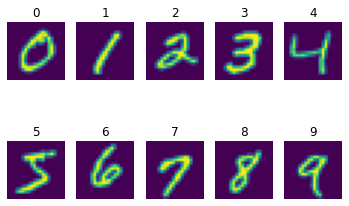

In [241]:
print('Imágenes: {}'.format(digitos.shape[0]))
print('Dimensiones: {}'.format(digitos.shape[1:]))

fig, ax = plt.subplots(2, 5)
step = 0
for r in range(2):
    for c in range(5):
        ax[r][c].set_title(etiquetas[step])
        ax[r][c].set_axis_off()
        ax[r][c].imshow(digitos[step])
        step += 500

#### Imagen sin correcion

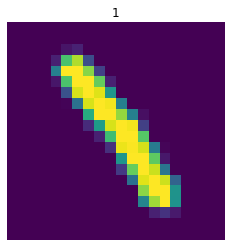

In [242]:
fig, ax = plt.subplots()
ax.set_title(etiquetas[521])
ax.set_axis_off()
ax.imshow(digitos[521])

#### Se realiza la correción geométrica calculando momentos

In [243]:
imagen_sin_correccion = digitos[521][:]
for i in range(numero_muestras):
    m = cv2.moments(digitos[i])
    if m['mu02'] > 1e-3:
        s = m['mu11'] / m['mu02']
        M = np.float32([[1, -s, 0.5 * TAMANIO_IMAGEN * s], [0, 1, 0]])
        digitos[i] = cv2.warpAffine(digitos[i], M, (TAMANIO_IMAGEN, TAMANIO_IMAGEN))

#### Imagen corregida

In [244]:
fig, ax = plt.subplots()
ax.set_title(etiquetas[521])
ax.set_axis_off()
ax.imshow(imagen_sin_correccion)

#### Se mezclan aleatoriamente las imágenes 

In [246]:
perm = np.random.permutation(numero_muestras)
digitos = digitos[perm]
etiquetas = etiquetas[perm]

#### Se define función para calcular los descriptores HOG

In [248]:
def calcular_hog(digitos):
    tamanio_ganador = (20, 20)
    tamanio_bloque = (10, 20)
    paso_bloque = (10, 10)
    tamanio_celda = (10, 10)
    nbins = 9
    hog = cv2.HOGDescriptor(tamanio_ganador, tamanio_bloque, paso_bloque, tamanio_celda, nbins)
    muestras = []
    for d in digitos: muestras.append(hog.compute(d))
    return np.array(muestras, np.float32)

#### Se obtiene el subjunto de entrenamiento y prueba, y se obtienen sus descriptores HOG

In [250]:
numero_entrenamiento = int(TASA_ENTRENAMIENTO * numero_muestras)
hog_muestras_entrenamiento = calcular_hog(digitos[:numero_entrenamiento])
hog_muestras_prueba = calcular_hog(digitos[numero_entrenamiento:])
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:numero_entrenamiento], etiquetas[numero_entrenamiento:]

#### Se crea el modelo KNN

In [252]:
K = 3
knn = cv2.ml.KNearest_create()
knn.train(hog_muestras_entrenamiento, cv2.ml.ROW_SAMPLE, etiquetas_entrenamiento)

True

#### Se crea el modelo de SVM

In [253]:
svm = cv2.ml.SVM_create()
svm.setGamma(2)
svm.setC(1)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setType(cv2.ml.SVM_C_SVC)
svm.train(hog_muestras_entrenamiento, cv2.ml.ROW_SAMPLE, etiquetas_entrenamiento)

True

#### Se define función para evaluar el modelo

In [256]:
def evaluar_modelo(caracteristicas, etiquetas, funcion_evaluar):
    prediccion = funcion_evaluar(caracteristicas).astype(np.int32)
    precision = (prediccion.T == etiquetas).mean() * 100
    matriz_confusion = np.zeros((CLASES, CLASES), np.int32)
    for etiqueta, p in zip(etiquetas, prediccion):
        matriz_confusion[etiqueta, p] += 1
    return precision, matriz_confusion

#### Se realiza la evaluación de los modelos

En las matrices de confusión se puede observar el número de predicciones correctas sobre la diagonal principal, mientras que cualquier valor fuera de ésta se trata de predicciones erroneas.

In [258]:
precision_knn, confusion_knn = evaluar_modelo(hog_muestras_prueba, etiquetas_prueba, lambda c: knn.findNearest(c, K)[1])
print('Precisión KNN (%)', precision_knn)
print('Matriz de confusión KNN:')
print(confusion_knn)

precision_svm, confusion_svm = evaluar_modelo(hog_muestras_prueba, etiquetas_prueba, lambda c: svm.predict(c)[1])
print('SVM accuracy: (%)', precision_svm)
print('SVM confusion matrix:')
print(confusion_svm)

Precisión KNN (%) 92.10000000000001
Matriz de confusión KNN:
[[102   0   0   0   0   0   1   0   0   0]
 [  0 100   0   0   1   0   0   1   0   0]
 [  0   0  95   6   1   0   2   1   1   2]
 [  0   0   3  90   0   1   0   0   1   1]
 [  2   1   2   2  90   0   1   1   0   1]
 [  0   0   0   5   1 110   1   0   2   0]
 [  3   0   0   0   0   0  84   0   2   0]
 [  1   0   1   4   3   0   0  91   1   4]
 [  1   0   0   1   2   2   1   0  75   1]
 [  0   0   1   1   4   0   0   2   3  84]]
SVM accuracy: (%) 95.39999999999999
SVM confusion matrix:
[[100   1   0   0   1   0   1   0   0   0]
 [  0  99   0   0   2   0   0   1   0   0]
 [  0   0 101   3   0   0   1   1   0   2]
 [  0   0   0  93   0   2   0   0   1   0]
 [  0   0   0   0  95   0   3   0   0   2]
 [  0   0   0   2   1 115   0   0   1   0]
 [  0   0   0   0   0   0  87   0   2   0]
 [  0   0   2   1   1   0   0  98   1   2]
 [  0   0   0   1   1   3   2   0  75   1]
 [  0   0   0   0   3   0   0   0   1  91]]


## Detección de rostros utilizando cascadas Haar/LBP

In [31]:
def detectar_rostros(video, detector, titulo_ventana):
    cap = cv2.VideoCapture(video)
    while True:
        estatus, frame = cap.read()
        if not estatus:
            break
        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rostros = detector.detectMultiScale(frame_gris, 1.3, 5)
        for x, y, w, h in rostros:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 3)
            text_size, _ = cv2.getTextSize('Rostro', cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            cv2.rectangle(frame, (x, y - text_size[1]), (x + text_size[0], y), (255, 255, 255), cv2.FILLED)
            cv2.putText(frame, 'Rostro', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        cv2.imshow(titulo_ventana, frame)
        if cv2.waitKey(1) == 27:
            break
        plt.imshow(frame[:,:,[2,1,0]])
    cv2.destroyAllWindows()


In [32]:
clasificador_haar = cv2.CascadeClassifier('files/haarcascade_frontalface_default.xml')
detectar_rostros('video/rostros.mp4', clasificador_haar, 'Detector de rostros')

## Detección de patrones AruCo 

Se necesita el paquete de contribución de OpenCV, para instalar:
    
    pip3 install opencv-contrib-python --user

In [23]:
import cv2.aruco as aruco

In [27]:
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
img = np.full((700, 700), 255, np.uint8)
img[100:300, 100:300] = aruco.drawMarker(aruco_dict, 2, 200)
img[100:300, 400:600] = aruco.drawMarker(aruco_dict, 76, 200)
img[400:600, 100:300] = aruco.drawMarker(aruco_dict, 42, 200)
img[400:600, 400:600] = aruco.drawMarker(aruco_dict, 123, 200)

img = cv2.GaussianBlur(img, (11, 11), 0)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))

#### Detección de las marcas en la imagen difuminada

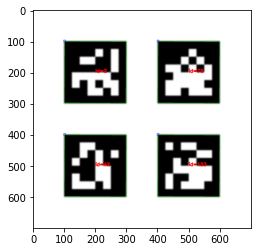

In [28]:
corners, ids, _ = aruco.detectMarkers(img, aruco_dict)
img_color = cv2.cvtColor(img, cv2
                         .COLOR_GRAY2BGR)
aruco.drawDetectedMarkers(img_color, corners, ids)

plt.imshow(img_color)

## Detector de códigos QR

Los códigos QR son otro tipo de objetos que se utiliza para almacenar información. A continuación se muestra cómo detectar códigos QR, así como remover la distorsión de la perspectiva para obtener vistas canónicas. 

#### Se define una función para encontrar el punto de intersección entre dos líneas

In [10]:
def interseccion(l1, l2):
    delta = np.array([l1[1]-l1[0], l2[1]-l2[0]]).astype(np.float32)
    delta = 1 / delta
    delta[:, 0] *= -1
    b = np.matmul(delta, np.array([l1[0], l2[0]]).transpose())
    b = np.diagonal(b).astype(np.float32)
    res = cv2.solve(delta, b)
    return res[0], tuple(res[1].astype(np.int32).reshape((2)))

#### Se define función para eliminar la distorsión en la perspectiva

In [21]:
def rectificar(imagen, esquinas, tamanio):
    rectangulo = np.zeros((4,2), dtype="float32")
    rectangulo[0] = esquinas[0]
    rectangulo[1] = esquinas[1]
    rectangulo[2] = esquinas[2]
    rectangulo[3] = esquinas[3]
    distorsion = np.array([
        [0, 0],
        [tamanio[1]-1, 0],
        [tamanio[1]-1, tamanio[0]-1],
        [0, tamanio[0]-1]], dtype = 'float32')
    M = cv2.getPerspectiveTransform(rectangulo, distorsion)
    return cv2.warpPerspective(imagen, M, tamanio)


#### Se define función para obtener las esquinas del código QR

In [23]:
def esquinas_qr(imagen):
    esquinas_encontradas = False
    esquinas = []
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, contornos, jerarquia = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    centros = []
    jerarquia = jerarquia.reshape((-1, 4))
    for i in range(jerarquia.shape[0]):
        siguiente, previo, hijo, padre = jerarquia[i]
        if all(v == -1 for v in jerarquia[i][:3]):
            if all(v == -1 for v in jerarquia[padre][:2]):
                ids = [i, padre, jerarquia[padre][3]]
                esquinas_cnts = []
                for id_ in ids:
                    cnt = contornos[id_]
                    apprx = cv2.approxPolyDP(cnt, cv2.arcLength(cnt, True) * 0.02, True)
                    if len(apprx) == 4:
                        esquinas_cnts.append(apprx.reshape((4, -1)))
                if len(esquinas_cnts) == 3:
                    cnts.append(esquinas_cnts)
                    all_pts = np.array(esquinas_cnts).reshape(-1, 2)
                    centros.append(np.mean(all_pts, 0))
    if len(centros) == 3:
        distancias_entre_puntos = np.linalg.norm(np.roll(centros, 1, 0) - centros, axis=1)
        max_dist_id = np.argmax(distancias_entre_puntos)
        indices_diag_pt_1 = max_dist_id
        indices_diag_pt_2 = (max_dist_id - 1) % len(centros)
        indices_esquinas_pt = (len(centros) - 1) * len(centros) // 2 - indices_diag_pt_1 - indices_diag_pt_2
        middle_pt = 0.5 * (centros[indices_diag_pt_1] + centros[indices_diag_pt_2])
        i_ul_pt = np.argmax(np.linalg.norm(cnts[indices_esquinas_pt][-1] - middle_pt, axis=1))
        ul_pt = cnts[indices_esquinas_pt][-1][i_ul_pt]
        for i in [indices_diag_pt_1, indices_diag_pt_2]:
            esquinas_cnts = cnts[i]
            outer_cnt = esquinas_cnts[-1]
            distancias_to_mp = np.linalg.norm(outer_cnt - middle_pt, axis=1)
            max_dist_id = np.argmax(distancias_to_mp)
            vec_from_mid_to_diag = outer_cnt[max_dist_id] - middle_pt
            vec_from_mid_to_corner = ul_pt - middle_pt
            cross_prod = np.cross(vec_from_mid_to_corner, vec_from_mid_to_diag)
            diff_idx = 0
            if cross_prod > 0:
                ur_pt = outer_cnt[max_dist_id]
                ur_pt_2 = outer_cnt[(max_dist_id + 1) % len(outer_cnt)]
            else:
                bl_pt = outer_cnt[max_dist_id]
                bl_pt_2 = outer_cnt[(max_dist_id - 1) % len(outer_cnt)]
        ret, br_pt = interseccion((bl_pt, bl_pt_2), (ur_pt, ur_pt_2))
        if ret == True:
            esquinas_encontradas = True
            esquinas = [ul_pt, ur_pt, br_pt, bl_pt]
    return esquinas_encontradas, esquinas
            

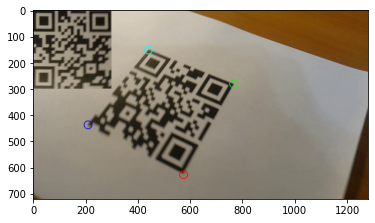

In [27]:
cap = cv2.VideoCapture('video/qr.mp4')
while True:
    ret, frame = cap.read()
    if ret == False:
        break
    result, corners = esquinas_qr(frame)
    qr_code_size = 300
    if result:
        if all((0, 0) < tuple(c) < (frame.shape[1], frame.shape[0]) for c in corners):
            rectified = rectificar(frame, corners, (qr_code_size, qr_code_size))
            cv2.circle(frame, tuple(corners[0]), 15, (0, 255, 0), 2)
            cv2.circle(frame, tuple(corners[1]), 15, (0, 0, 255), 2)
            cv2.circle(frame, tuple(corners[2]), 15, (255, 0, 0), 2)
            cv2.circle(frame, tuple(corners[3]), 15, (255, 255, 0), 2)
            frame[0:qr_code_size, 0:qr_code_size] = rectified
    cv2.imshow('QR code detection', frame)
    k = cv2.waitKey(100)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()
plt.imshow(frame[:,:,[2,1,0]])
            